In [ ]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

import sys
sys.path.append('../..')
import snowFun

In [43]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')
folder_debris = os.path.join(folder_AGVA, 'debris cover')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'Area', 'geometry'])

# open debris cover
path_debris = os.path.join(folder_debris, 'Herreid_debriscover', 'SupplementaryInformation', '01Alaska', "01Alaska_minGl2km2_debrisCover.shp")
debris_gdf = gpd.read_file(path_debris).drop(columns=['debara_km2', 'debTot_km2'])

all_rgi = rgi_gdf['RGIId'].values

In [44]:
print(rgi_gdf.crs)
print(debris_gdf.crs)

EPSG:3338
EPSG:3338


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


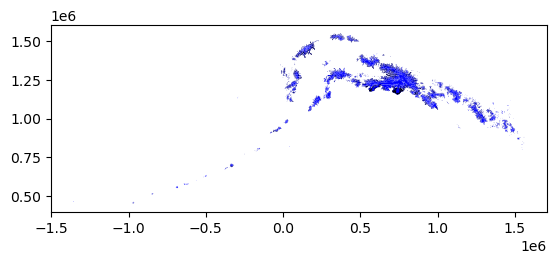

In [61]:
# for each rgi outline, clip the debris cover to those bounds. save to new shapefile.
all_debris_list = []
all_rgi_list = []

for idx, rgiid in enumerate(all_rgi):
    if idx%100==0: print(idx)
    
    # select just this rgi outline
    rgi_i = rgi_gdf[rgi_gdf['RGIId']==rgiid]
    
    # clip debris cover to this outline
    rgi_debris = gpd.clip(debris_gdf, rgi_i.geometry).dissolve()
    
    # append to list
    rgi_debris['RGIId']=rgiid
    all_debris_list.append(rgi_debris)
    all_rgi_list.append(rgi_i)
    
all_debris_gdf = pd.concat(all_debris_list)
all_rgi_gdf = pd.concat(all_rgi_list)

fig,axs = plt.subplots()
all_rgi_gdf.plot(ax=axs, color='blue')
all_debris_gdf.plot(ax=axs, color='black')

all_debris_gdf.head(10)
all_debris_gdf.to_file(os.path.join(folder_debris, 'shp', 'rgi_debris_cover.shp'))

In [133]:
# now for each debris-cover outline, clip the glacier mask to this extent and resave
# clipped = xds.rio.clip(geometries)
for idx, rgiid in enumerate(all_rgi):
#     if idx!=104: continue
    if idx%100==0: print(idx)
    
    # open the mask
    glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgiid}_mask.nc")).glacier.astype('uint8')
    
    # grab the debris
    debris_i = all_debris_gdf[all_debris_gdf['RGIId']==rgiid]
    
    if len(debris_i.geometry.values)>0:
        # clip to debris
        clipped = glacier_mask.rio.clip(debris_i.geometry.buffer(20).values, drop=False).astype('uint8')
    
    else:
        clipped = xr.where(glacier_mask==0, 0, 0)
        
    # save
    out_path = os.path.join(folder_debris, 'raster', f"{rgiid}_debris.tif")
    clipped.rio.to_raster(out_path, dtype="uint8")
    
# fig,axs = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)
# glacier_mask.plot(ax=axs[0])
# debris_i.plot(ax=axs[1])
# clipped.plot(ax=axs[2])

0


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

100


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


200


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

300


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

400


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

500


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

600


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

700


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

800


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

900


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

1000


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


1100


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

1200


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

1300


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


1400


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


1500


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

1600


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


1700


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

1800


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


1900


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

2000


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

2100


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

2200


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

2300


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


2400


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

2500


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

2600


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


2700


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

2800


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

2900


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW

3000


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeW